<a href="https://colab.research.google.com/github/space4VV/LLM_trailblazr/blob/main/chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coding LLM architecture

In [62]:
# configuration
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size BPT Tokenizer
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate 10%
    "qkv_bias": False       # Query-Key-Value bias
}

In [63]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        #transformer block placeholder
        self.transformer_block= nn.Sequential(*[DummyTransformerBlock(config) for _ in range(config["n_layers"])])
        self.ln_f = nn.LayerNorm(config["emb_dim"])

        #Layernorm placeholder
        self.final_norm = DummyLayerNorm(config["emb_dim"])

        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"],bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.token_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.transformer_block(x)
        x = self.ln_f(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

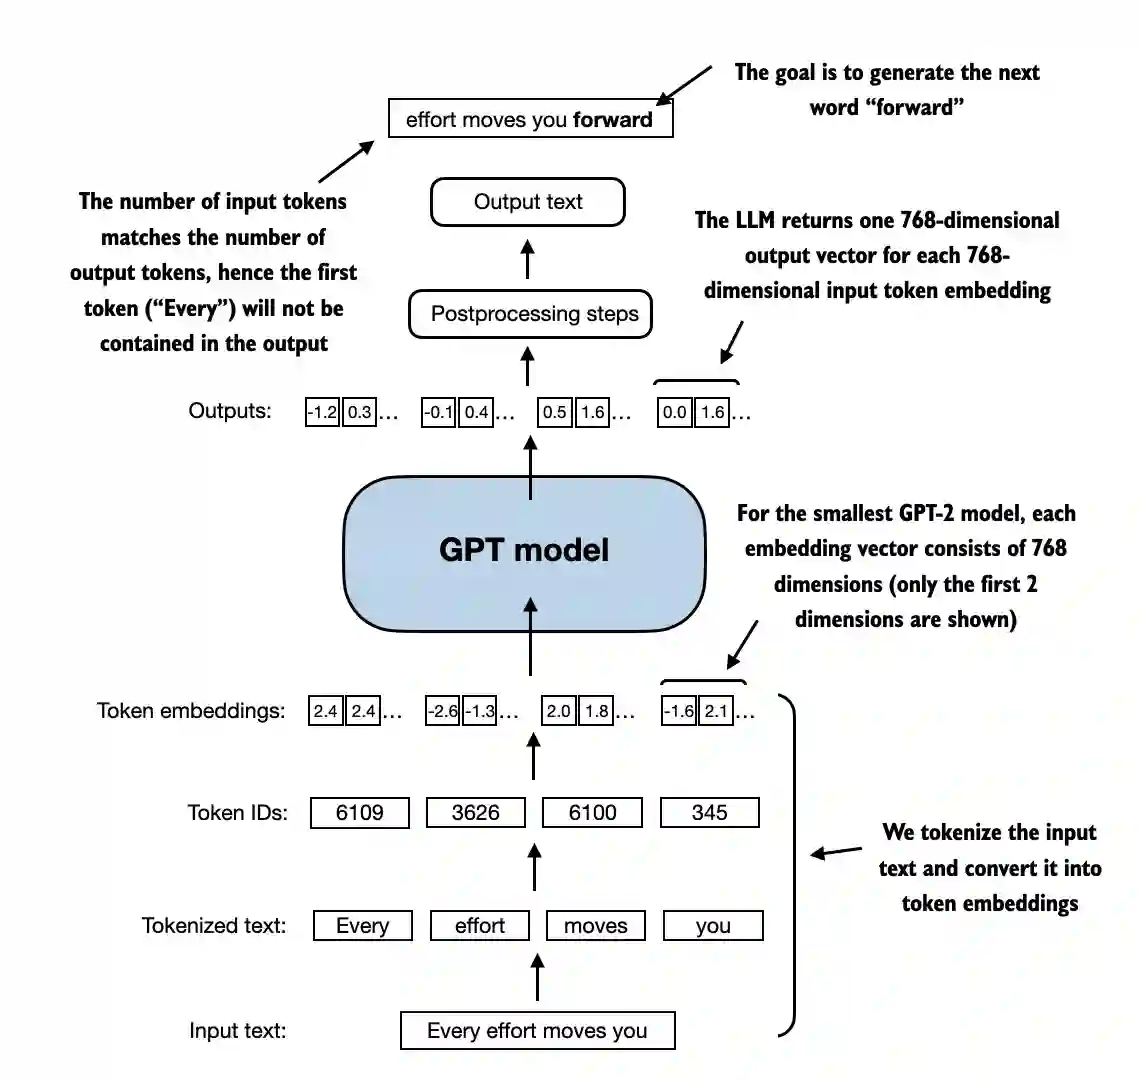

In [64]:
!pip install tiktoken

In [65]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [66]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.5998,  0.1788, -0.4855,  ..., -1.0338,  0.1756, -0.3791],
         [-0.3048,  0.1200,  0.3618,  ..., -0.2633,  1.0311,  0.5753],
         [ 0.4025,  1.0698, -0.1543,  ...,  0.7827,  0.0786,  0.5037],
         [ 0.0938,  1.6024, -0.6251,  ...,  0.8712, -0.1122, -0.3924]],

        [[-0.9718, -0.0670, -0.6994,  ..., -1.1791, -0.3173, -0.4363],
         [-0.6117,  0.6015, -0.0475,  ..., -0.0795,  0.1833,  0.7967],
         [ 0.1158,  0.7813, -0.1099,  ...,  0.0522, -0.1281,  0.1061],
         [ 0.1734, -0.6275,  0.1344,  ...,  1.7331, -0.2619, -0.2139]]],
       grad_fn=<UnsafeViewBackward0>)


In [67]:
logits

tensor([[[-0.5998,  0.1788, -0.4855,  ..., -1.0338,  0.1756, -0.3791],
         [-0.3048,  0.1200,  0.3618,  ..., -0.2633,  1.0311,  0.5753],
         [ 0.4025,  1.0698, -0.1543,  ...,  0.7827,  0.0786,  0.5037],
         [ 0.0938,  1.6024, -0.6251,  ...,  0.8712, -0.1122, -0.3924]],

        [[-0.9718, -0.0670, -0.6994,  ..., -1.1791, -0.3173, -0.4363],
         [-0.6117,  0.6015, -0.0475,  ..., -0.0795,  0.1833,  0.7967],
         [ 0.1158,  0.7813, -0.1099,  ...,  0.0522, -0.1281,  0.1061],
         [ 0.1734, -0.6275,  0.1344,  ...,  1.7331, -0.2619, -0.2139]]],
       grad_fn=<UnsafeViewBackward0>)

## Layer norm
This centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1
This stabilizes training and enables faster convergence to effective weights
Layer normalization is applied both before and after the multi-head attention module within the transformer block

In [68]:
#example
torch.manual_seed(123)

batch_example =torch.randn(2,5)# 2 training example with 5 features each
layer =nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [69]:
#mean and variance
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)
print(mean)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [70]:
#Subtracting the mean and dividing by the square-root of the variance
#(standard deviation) centers the inputs to have a mean of 0 and a variance of
#1 across the column (feature) dimension:

In [71]:
out_norm = (out-mean)/torch.sqrt(var)
print("Normalized layer output:",out_norm)

mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print("Mean:",mean)
print("Variance:",var)

Normalized layer output: tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean: tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [72]:
# implement layer norm class
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps= 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1,keepdim=True)
    norm_x = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x + self.shift

In [73]:
layer_norm = LayerNorm(emb_dim=5)
out_layer_norm = layer_norm(batch_example)

In [74]:
mean = out_layer_norm.mean(dim=-1,keepdim=True)
var = out_layer_norm.var(dim=-1,keepdim=True,unbiased=False)
print("Mean:",mean)
print("Variance:",var)

Mean: tensor([[-1.4901e-08],
        [ 2.3842e-08]], grad_fn=<MeanBackward1>)
Variance: tensor([[0.8000],
        [0.8000]], grad_fn=<VarBackward0>)


In [75]:
# commonly used activation functions in LLM are:
# GELU
# SwiGLU


In [76]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
      return 0.5 * x * (1 + torch.tanh(
          torch.sqrt(torch.tensor(2.0 / torch.pi)) *
          (x + 0.044715 * torch.pow(x, 3))
      ))



As we can see, ReLU is a piecewise linear function that outputs the input directly
if it is positive; otherwise, it outputs zero

GELU is a smooth, non-linear function that approximates ReLU but with a non-zero
gradient for negative values (except at approximately -0.75)


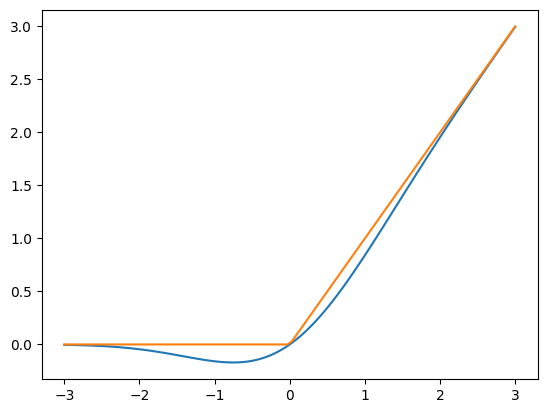

In [77]:
import matplotlib.pyplot as plt
gelu,relu = GELU(),nn.ReLU()

#example
x= torch.linspace(-3,3,100)
gelu_out = gelu(x)
relu_out = relu(x)

plt.plot(x,gelu_out)
plt.plot(x,relu_out)
plt.show()

In [78]:
class FeedForward(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"], 4*config["emb_dim"]), # outputs after 1st layer is projected to 4 dim
        nn.GELU(),
        nn.Linear(4*config["emb_dim"],config["emb_dim"]) # projeted back from 4dim to original input
    )

  def forward(self,x):
    return self.layers(x)

In [79]:
print(GPT_CONFIG_124M['emb_dim'])

768


In [80]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape = [batch_size,no_tokens,emb_size]
x = torch.randn(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [81]:
# adding shortcut connections or skip or residuals
# to mitigate vanishing gradient problems
# achieved by adding the output of one layer to the output of later layer


class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self,layer_sizes,use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
    nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
    nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
    nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
    nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
    nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
])

  def forward(self,x):
    for layer in self.layers:
      #compute the output of current layer
      layer_output = layer(x)
      if self.use_shortcut and x.shape ==  layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

def print_gradients(model,x):
  #forward
  output = model(x)
  target = torch.tensor([[0.]])

  #calculate loss based on how close the target -output are

  loss = nn. MSELoss()
  loss = loss(output,target)
  loss.backward()

  for name,param in model.named_parameters():
    if "weight" in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [82]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [83]:
# with shortcuts
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576




## Connecting attention and linear layers



## Coding GPT Model

In [87]:
class GPTModel(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.config = config
    self.token_emb = nn.Embedding(config["vocab_size"],config["emb_dim"])
    self.pos_emb = nn.Embedding(config["context_length"],config["emb_dim"])
    self.drop_emb = nn.Dropout(config["drop_rate"])

    self.transformer_blocks = nn.Sequential(
        *[TransformerBlock(config) for _ in range(config["n_layers"])])
    self.final_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"],config["vocab_size"],bias = False)

  def forward(self,in_idx):
    batch_size,seq_len = in_idx.shape
    tok_embeds = self.token_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits



In [88]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("input_batch",batch)
print("Output shape:", out.shape)
print(out)

NameError: name 'TransformerBlock' is not defined